# Chapter 1 - Getting Started
Based on "Forecasting: Principles and Practice, the Pythonic Way".

Let us start with an overview of forecasting and the data we shall be using throught these notes.
## **1. Basic Steps**
a) Problem Definition

b) Gather Data

c) Preliminary Exploratory Analysis: Always start by graphing the data. Are there consistent patterns? Is there a significant trend? Is seasonality important? Is there evidence of the presence of business cycles? Are there any outliers in the data that need to be explained by those with expert knowledge? How strong are the relationships among the variables available for analysis? 

d) Picking a Model

e) Evaluate the forecast



# Chapter 2 -  Time series graphics
Next, let us explore our dataset and investigate the time series.

## **1. Our Dataset**

The data we are using is from the Mosqlimate research group, and consists in the number of dengue reported cases
at the different municipalities of Brazil from 2010 to 2024.

Our target column is `casos`. Each municipality has a unique `geocode`. Moreover, the data is divided into epiweeks (epidemiological weeks).

In [1]:
import polars as pl 
import numpy as np
import os
from dotenv import load_dotenv
from matplotlib import pyplot as plt
import seaborn as sns
from lets_plot import *
LetsPlot.setup_html()

# Load environment variables from .env file
load_dotenv()
# Retrieve the dataset path from the environment variable
DATASET = os.getenv('DATASET')
df = pl.read_parquet(DATASET)
df.head()

date,epiweek,week,month,year,geocode,uf,casos,regional_geocode,macroregional_geocode,train_1,target_1,train_2,target_2,train_3,target_3,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days,population,municipality_latitude,municipality_longitude,cope_forecast_temp_med_1,cope_forecast_temp_med_2,cope_forecast_temp_med_3,cope_forecast_temp_med_4,cope_forecast_temp_med_5,cope_forecast_temp_med_6,cope_forecast_umid_med_1,cope_forecast_umid_med_2,cope_forecast_umid_med_3,cope_forecast_umid_med_4,cope_forecast_umid_med_5,cope_forecast_umid_med_6,cope_forecast_precip_tot_1,cope_forecast_precip_tot_2,cope_forecast_precip_tot_3,cope_forecast_precip_tot_4,cope_forecast_precip_tot_5,cope_forecast_precip_tot_6
datetime[ms],i64,i64,i8,i64,i64,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-12-01 00:00:00,201349,49,12,2013,4123501,"""PR""",0,41020,4108,true,false,true,false,true,false,23.519843,26.687414,30.6265,0.0,8.0212,38.1128,0.963314,0.9652,0.967029,61.4359,77.708971,90.673443,7.106657,7,24895,-54.31352,-24.867715,24.160638,24.800623,24.436212,23.468561,21.192194,18.943079,73.097785,76.295706,79.338833,74.958144,75.324096,76.134163,0.0000583,0.0000668,0.0000771,0.0000419,0.0000473,0.000048
2018-12-30 00:00:00,201901,1,12,2019,2110005,"""MA""",0,21014,2110,true,false,true,false,true,false,22.990586,25.998929,29.906029,1.3526,12.3684,42.5034,0.978829,0.980914,0.982929,65.257229,83.801243,96.0528,6.915443,7,72667,-46.032927,-4.292059,27.059012,25.709636,25.487531,25.502699,25.405562,25.933427,74.006455,84.112711,86.10091,87.430035,87.588848,81.174514,0.0000481,0.0000855,0.0000992,0.0001153,0.0001011,0.0000365
2015-04-19 00:00:00,201516,16,4,2015,2501005,"""PB""",2,25002,2503,true,false,true,false,true,false,21.973514,25.146,29.699557,0.8293,7.6345,16.8829,0.955057,0.956686,0.958371,52.408957,76.367814,93.965471,7.726043,7,20051,-35.774475,-6.532502,25.547571,25.385431,25.033075,24.557764,24.541376,25.357355,73.954272,72.322172,67.545392,64.238681,62.235809,60.322318,0.0000457,0.0000191,0.0000083,0.000006,0.0000058,0.0000047
2017-04-23 00:00:00,201717,17,4,2017,2919405,"""BA""",0,29007,2911,true,false,true,false,true,false,20.1096,24.163671,28.866571,0.002,1.0882,3.2339,0.9101,0.912143,0.914271,44.708429,65.973843,88.480671,8.756971,7,12969,-42.445143,-14.613054,23.317242,22.890823,21.696303,21.019387,21.817704,23.537374,66.592168,59.800459,57.117379,56.144655,53.31597,50.459479,0.000019,0.0000038,0.0000021,0.0000025,0.000003,0.0000074
2022-10-16 00:00:00,202242,42,10,2022,4304655,"""RS""",0,43002,4314,false,true,true,false,true,false,14.966214,19.113914,23.610071,0.3002,10.1847,37.4767,0.962471,0.964757,0.966671,61.949343,79.756571,94.670914,8.643857,7,3119,-54.561238,-28.949222,18.872215,21.615514,24.09258,24.874645,24.50893,22.414141,69.50884,64.249069,61.149872,66.283014,71.351457,70.466555,0.0000536,0.0000482,0.0000417,0.0000581,0.0000605,0.000048


In [2]:
df['year'].unique()

year
i64
2010
2011
2012
2013
2014
…
2021
2022
2023


Let's visualize our target.

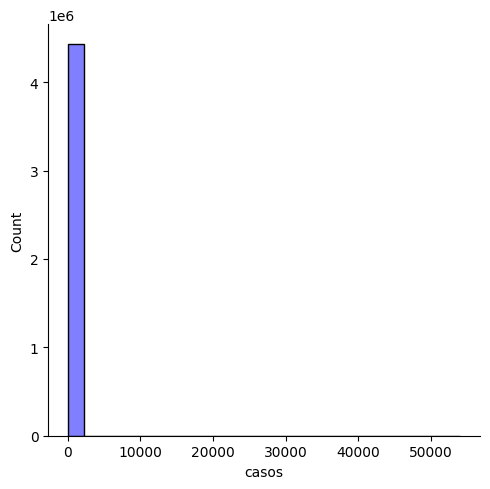

In [3]:
sns.displot(data=df, x='casos', fill=True, color='blue', alpha=0.5)

Our variable is clearly heavy tailed. In order to better understand it, we must scale it. 
Moreover, we will also create a new variable that is the number of cases per 100,000 inhabitants, which we will call `dir` (dengue incidence rate). 

In [3]:
df = df.with_columns(
    np.log1p(pl.col('casos')).alias('log_casos'),
    ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
    np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
)

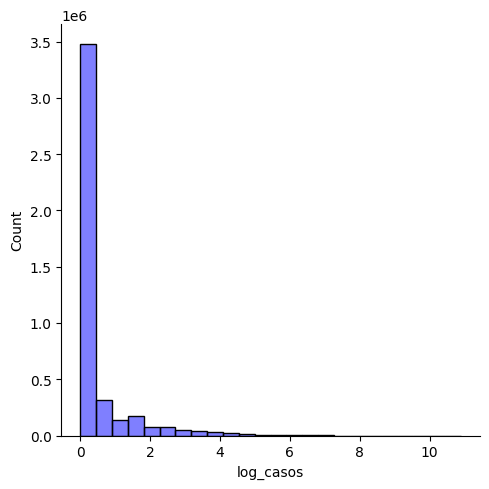

In [5]:
sns.displot(data=df, x='log_casos', fill=True, color='blue', alpha=0.5)

The data has a large number of `0` cases. It might be that most of the weeks have no cases, and only a few weeks have a large number of cases. 
Thus, let us see the distribution of the number of cases per municipality summed over a whole year.

Note, our dataset has **5567** municipalities.

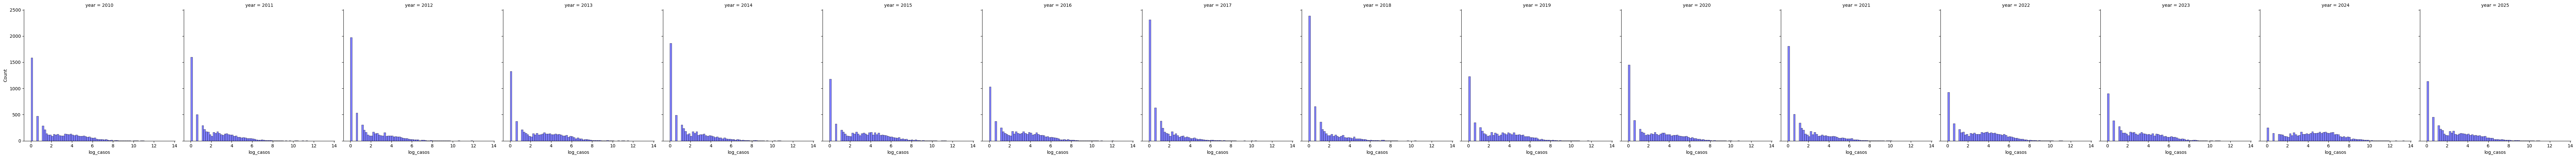

In [4]:
gdf = df.group_by(['geocode','year']).agg(
    pl.col('casos').sum().alias('casos'),
).sort('year')
gdf = gdf.with_columns(
    np.log1p(pl.col('casos')).alias('log_casos')
)

sns.displot(data=gdf, x='log_casos',fill=True, color='blue', alpha=0.5, col='year')

Note that we still have many cases with zeros, i.e., many municipalities report 0 across the whole year, with the exception of 2024,
where the number of municipalities with 0 cases shrunk under 500.

## **2. Plotting Series**

Next, let us plot some time series with regards to our dataset.
We have too many municipalities. Let us aggregate our data.

In [5]:
# Aggregate
def agg_dengue(df,group=''):
    if group == '':
        cols = ['date','epiweek','week','year']
    else:
        cols = ['date','epiweek','week','year',group]
    gdf = df.group_by(cols).agg(
        pl.col('casos').sum().alias('casos'),
        pl.col('population').mean().alias('population'),
    ).sort('year')
    
    gdf = gdf.with_columns(
        ((pl.col('casos')/pl.col('population')) *100000).alias('dir'),
        np.log1p(pl.col('casos')).alias('log_casos'),
        np.log1p(((pl.col('casos')/pl.col('population')) *100000)).alias('log_dir'),
    )
    return gdf

<Axes: xlabel='date', ylabel='casos'>

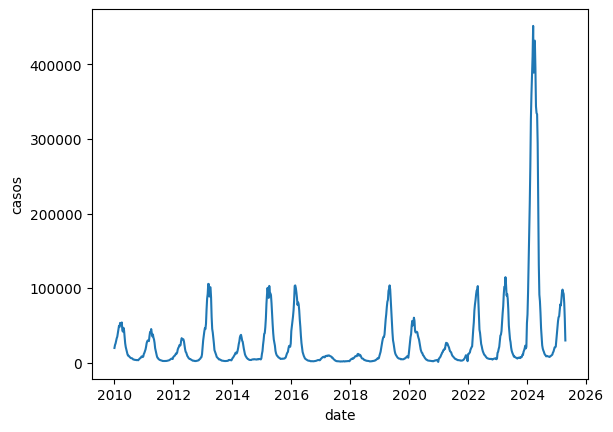

In [6]:
sns.lineplot(data=agg_dengue(df),x='date',y='casos')

<Axes: xlabel='date', ylabel='log_casos'>

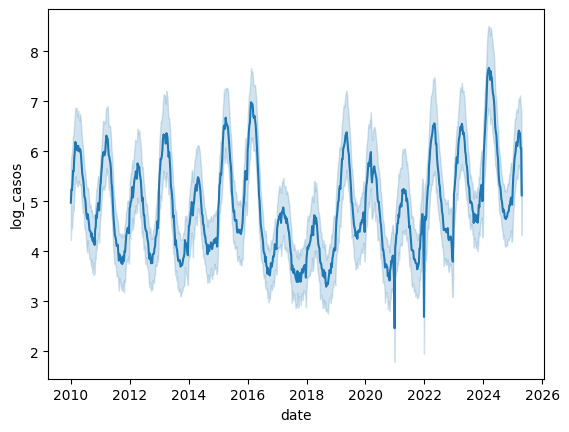

In [7]:
sns.lineplot(data=agg_dengue(df,'uf'),x='date',y='log_casos')

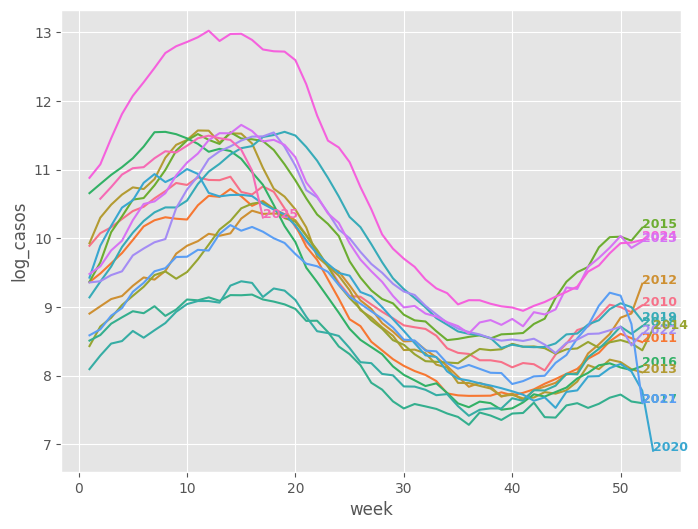

In [67]:
gdf = agg_dengue(df)
plt.style.use('ggplot')
unique_years = gdf["year"].unique()
year_palette = sns.color_palette("husl", n_colors=len(unique_years))

plt.figure(figsize=(8, 6))
sns.lineplot(
    data=gdf,
    x="week",
    y="log_casos",
    hue="year",
    palette=year_palette,
    legend=False,
)

min_year = unique_years.min()
for year, subset in gdf.sort('week').group_by("year"):
    plt.text(
        subset["week"][-1],
        subset["log_casos"][-1],
        str(year[0]),
        fontsize=9,
        weight="bold",
        color=year_palette[year[0] - min_year],
    )

plt.show()

For dengue in Brazil, the season for dengue is not well captured by breaking into years. Instead, it is better to go from
epiweek 41 from one year, to the epiweek 40 for the other.

In [85]:
gdf = gdf.with_columns(
    pl.when(pl.col('week') < 41)
    .then(
        (pl.col('year')-1).cast(pl.Utf8) + '-' + pl.col('year').cast(pl.Utf8)
    )
    .otherwise(
        pl.col('year').cast(pl.Utf8) +'-' + (pl.col('year')+1).cast(pl.Utf8)
    )
    .alias('season')
)

gdf = gdf.with_columns(
    pl.when(pl.col('week') < 41)
    .then(
        (pl.col('week') + 11)
    )
    .otherwise(
        (pl.col('week') - 40)
    )
    .alias('season_week')
)
gdf

date,epiweek,week,year,casos,population,dir,log_casos,log_dir,season,season_week
datetime[ms],i64,i64,i64,i64,f64,f64,f64,f64,str,i64
2010-04-25 00:00:00,201017,17,2010,46804,34333.28183,136322.534596,10.753745,11.822786,"""2009-2010""",28
2010-12-12 00:00:00,201050,50,2010,8078,34333.28183,23528.190635,8.997023,10.065997,"""2010-2011""",10
2010-02-28 00:00:00,201009,9,2010,49200,34333.28183,143301.185841,10.803669,11.872711,"""2009-2010""",20
2010-06-06 00:00:00,201023,23,2010,14720,34333.28183,42873.850723,9.59703,10.666041,"""2009-2010""",34
2010-07-18 00:00:00,201029,29,2010,6865,34333.28183,19995.175626,8.834337,9.903296,"""2009-2010""",40
…,…,…,…,…,…,…,…,…,…,…
2025-04-06 00:00:00,202515,15,2025,79955,39982.74259,199973.775735,11.289232,12.205947,"""2024-2025""",26
2025-01-12 00:00:00,202503,3,2025,46369,39982.74259,115972.534639,10.744408,11.661117,"""2024-2025""",14
2025-02-09 00:00:00,202507,7,2025,70552,39982.74259,176456.129393,11.164119,12.080833,"""2024-2025""",18


In [86]:
gdf.filter(pl.col('week') == 53)

52 - 41

11

In [88]:
np.array(gdf['season_week'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [89]:
# plt.style.use('ggplot')
# unique_years = gdf["season"].unique()
# year_palette = sns.color_palette("husl", n_colors=len(unique_years))

# plt.figure(figsize=(8, 6))
# sns.lineplot(
#     data=gdf,
#     x="week",
#     y="log_casos",
#     hue="season",
#     palette=year_palette,
#     legend=False,
# )

# min_year = unique_years.min()
# for year, subset in gdf.sort('week').group_by("season"):
#     plt.text(
#         subset["week"][-1],
#         subset["log_casos"][-1],
#         str(year[0]),
#         fontsize=9,
#         weight="bold",
#         # color=year_palette[year[0] - min_year],
#     )

# plt.show()

In [90]:
(
    ggplot(data=gdf)
    + geom_line(aes(x='season_week',y='log_dir',color=as_discrete('season',order=1)))
    + scale_color_brewer(type='seq',palette='Accent',direction=1)
)

In [16]:
# import altair as alt

# selection = alt.selection_point(fields=['Year'])
# color = (
#     alt.when(selection)
#     .then(alt.Color("Year:O").legend(None))
#     .otherwise(alt.value("lightgray"))
# )

# line = alt.Chart(gdf).mark_line().encode(
#     x='week:Q',
#     y='log_casos:Q',
#     color='year',
#     tooltip='year:O'
# )

# legend = alt.Chart(gdf).mark_point().encode(
#     alt.Y('year:O').axis(orient='right'),
#     color=color
# ).add_params(
#     selection
# )

# line | legend

We can clearly see that there is a seasonal pattern for dengue  

In [ ]:
(
    ggplot(data=fortaleza.filter(pl.col('year')>2018))
    # + geom_line(aes(x='date',y='casos'))
    # + geom_line(aes(x='date',y='dir'))
    # + geom_line(aes(x='date',y='log_casos'))
    + geom_line(aes(x='week',y='log_dir',color=as_discrete('year',order=1)))
    + scale_color_brewer(type='seq',palette='Blues',direction=1)
)